# 공식 문서 튜토리얼 
## 도구로 챗봇 강화하기 

본 문서에서는 이해의 편의를 위해 prompt를 영어 대신 한글로 사용하였음. 

또한 chatantropic대신 chatopenai를 사용하여 공식 문서와 결과가 다소 다를 수 있음. 

In [ ]:
import getpass
import os

#환경변수에 값 등록하기 위한 함수
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

In [3]:
# Tavily_api_key 입력 
_set_env("TAVILY_API_KEY")

#openai api key 저장. 입력시 실수하지 않도록 주의할 것. 
_set_env("OPENAI_API_KEY")

In [5]:
#tool 정의 
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2) #최대 2개까지만 결과로 받음. 
tools = [tool] #tools는 tool을 도구로 가짐. 필요한 경우 복수의 도구를 포함할 수 있음. 
tool.invoke("LangGraph에서 'node'는 뭐야?") #입력을 받아 결과를 출력

[{'url': 'https://teach-meaning.tistory.com/1139',
  'content': 'LangGraph 의 노드 함수 역할을 한다. 현재 상태 State 를 입력으로 받아 업데이트된 상태를 반환하는데, 특히 챗봇의 메시지 리스트를 업데이트하는 방식'},
 {'url': 'https://digitalbourgeois.tistory.com/377',
  'content': "노드(Node)와 엣지(Edge)를 사용하여 데이터 흐름을 시각화하고 제어할 수 있으며, 조건부 엣지(Conditional Edge), Human-in-the-loop, Checkpointer, State 등의 기능을 통해 유연하고 강력한 파이프라인을 구성할 수 있습니다. 조건부 엣지(Conditional Edge): 특정 조건에 따라 노드 간의 연결을 동적으로 변경할 수 있습니다. from langgraph import Node, Edge, Graph, State graph.add_nodes([retriever, generator, evaluator]) graph.add_edge(Edge(retriever, generator)) graph.add_edge(Edge(evaluator, retriever, condition=feedback_condition)) graph.add_node(human_feedback) graph.add_node(checkpoint) graph.add_edge(Edge(evaluator, human_feedback, condition=lambda state: not state['satisfied'])) graph.add_edge(Edge(human_feedback, retriever)) 순환 처리와 재처리를 통해 LLM의 한계를 극복하고, 더욱 정확하고 신뢰성 있는 응답을 제공할 수 있습니다. 앤트로픽의 새로운 비밀 무기: Contextual Retrieval로 LLM의 한계를 넘어서다\xa0\xa0(0)2024.10.04출처까지 알려주

In [6]:
from typing import Annotated
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

#스테이트 정의 
class State(TypedDict):
    messages: Annotated[list, add_messages]

#노드 기능용 함수 정의 
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

#llm 모델 선언. 
llm  = ChatOpenAI(model="gpt-4o-mini")
# llm에게 호출을 위한 도구를 추가. 
llm_with_tools = llm.bind_tools(tools)


#그래프 구조 선언. 
graph_builder = StateGraph(State)
#그래프에 chatbot 노드 생성
graph_builder.add_node("chatbot", chatbot)

In [7]:
import json
from langchain_core.messages import ToolMessage

class BasicToolNode:
    """마지막 ai message에서 요청된 도구를 실행하는 도구 ."""

    #tools의 리스트를 받아 딕셔너리 형태로 변환하여 저장하는 생성자
    def __init__(self, tools: list) -> None: #-> None는 이 함수는 값을 반환하지 않는다는 타입 힌트. 
        self.tools_by_name = {tool.name: tool for tool in tools} #tool.name과 tools의 각 요소를 연결한 딕셔너리 생성. 

    # 요청 처리용 함수
    def __call__(self, inputs: dict): #inputs는 dict 형식
        # inputs에서 messages를 획득. 값이 없는 경우 error 발생
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = [] #결과 저장용 리스트 
        
        for tool_call in message.tool_calls:# message에서 tool_calls 값 획득 및 각각 처리 
            #현재 호출된 도구를 전달된 인수를 사용하여 실행. 
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"] # 도구 실행에 필요한 매개변수.
            )
            # 출력에 ToolMessage 내용 추가. 
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs} #output를 messages 키의 값으로 갖는 딕셔너리 반환. 

#tool_node 변수에 함수 할당. 
tool_node = BasicToolNode(tools=[tool]) # tools는 미리 리스트로 선언해 두는 것이 좋음. 
#tool_node 사용할 노드 생성. 
graph_builder.add_node("tools", tool_node)

In [8]:
def route_tools(state: State,):
    """
    마지막 메세지가 tool calls가 있는경우 
    conditional_edge가 toolnode로 경로 설정 한다. 
    그 외에는 end 노드로 경로 설정
    """
    if isinstance(state, list): #state 객체가 list인 경우
        ai_message = state[-1] #ai_message는 state의 마지막 값. 
    elif messages := state.get("messages", []): #state가 딕셔너리일 때 message값 반환. 없는 경우 빈 리스트 반환
        ai_message = messages[-1] #message의 마지막 값 할당. 
    else: #그 외의 경우 value error 반환 
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    # ai_message가 tool_calls를 가지고 있고, ai_message.tool_calls의 길이가 0 초과일 때 
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools" # tools를 반환. 
    return END


# 챗봇이 도구를 사용하라고 요청하면, route_tools 함수가 tools를 반환하고 직접 응답해도 괜찮은 경우 "END"를 선택합니다. 
# 이 조건부 라우팅은 메인 에이전트 루프를 정의합니다
# 조건부 노드는 무조건 단일 노드에서 시작함. 
graph_builder.add_conditional_edges(
    "chatbot", #출발 노드
    route_tools, #경로 지정 함수. 함수 결과에 따라 연결되는 노드가 변경.
    {"tools": "tools", END: END}, 
    # 위의 딕셔너리를 사용하면 출력을 특정 노드로 해석하는 그래프 생성 가능. 
    # 항등함수(identity function)가 기본값이지만, 노드 이름을 따로 지정하고 싶은 경우에는 다음과 같은 예시를 사용할 수 있다. e.g "tools": "my_tools"
)

graph_builder.add_edge("tools", "chatbot") #tool이 호출될 때 마다 챗봇으로 돌아가 다음 단계를 결정하기 위해 tools 노드에서 chatbot로 이동할 경로를 설정. 
graph_builder.add_edge(START, "chatbot") # 시작지점에서 chatbot 노드로 이동할 경로를 설정. 
graph = graph_builder.compile()

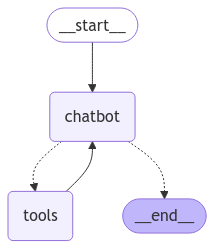

In [9]:
#시각화 절차 
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [10]:
#그래프 업데이트 하기 위한 함수. 
def stream_graph_updates(user_input: str): #문자열로 입력
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):# 메세지를 초기화 하는 기능을 함. 
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

In [12]:
#지속된 대화를 수행하기 위한 입력. 
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        print(user_input)
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

langgraph에 대해 무었을 알고 있어?
Assistant: 
Assistant: [{"url": "https://github.com/langchain-ai/langgraph", "content": "GitHub - langchain-ai/langgraph: Build resilient language agents as graphs. LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows. Let's build a tool-calling ReAct-style agent that uses a search tool! The simplest way to create a tool-calling agent in LangGraph is to use create_react_agent: Define the tools for the agent to use Define the tools for the agent to use This means that after tools is called, agent node is called next. workflow.add_edge(\"tools\", 'agent') Normal edge: after the tools are invoked, the graph should always return to the agent to decide what to do next LangGraph adds the input message to the internal state, then passes the state to the entrypoint node, \"agent\"."}, {"url": "https://www.langchain.com/langgraph", "content": "Build and scale agentic applications with LangGraph 

In [ ]:
#주석 없이 구현. 
from typing import Annotated
from langchain_anthropic import ChatAnthropic # 공식문서와 동일하게 재현하고 싶은 경우에 사용. 
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearchResults(max_results=2)
tools = [tool]
# llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm  = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

#basic tool node 함수 대신 ToolNode 사용. 해당 기능을 지원하는 공식 api가 존재
tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

#route_tools 함수 대신 tools_condition 사용. 해당 기능을 지원하는 공식 api가 존재
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition, #메세지의 내부에 tool_calls가 존재하면 tool로 전달, 아닐경우 end로 연결. 
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

In [ ]:
#그래프 업데이트 하기 위한 함수. 
def stream_graph_updates(user_input: str): #문자열로 입력
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):# 메세지를 초기화 하는 기능을 함. 
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

# 대화용 함수
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break